In [210]:
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from itertools import combinations
from itertools import permutations
from collections import Counter 
import random
warnings.filterwarnings('ignore')

tutorial to execute this notebook:
1. create a drive folder(in your private drive) called ekimetrics (the name should be the same as written here 
2. create inside another folder called "data"
3. put all the datas we are given inside that folder(with the same file names) 
4. execute the notebook and follow the further instructions on the output 

In [2]:
!pip install httplib2==0.15.0

!pip install google-api-python-client==1.6

     |████████████████████████████████| 102kB 3.0MB/s 
  Found existing installation: httplib2 0.17.4
    Uninstalling httplib2-0.17.4:
      Successfully uninstalled httplib2-0.17.4
     |████████████████████████████████| 61kB 2.4MB/s 
ERROR: firebase-admin 4.4.0 has requirement google-api-python-client>=1.7.8, but you'll have google-api-python-client 1.6.0 which is incompatible.
ERROR: earthengine-api 0.1.264 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.6.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [3]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 3.8MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=c2eabe2e2583bb53e45fad1982f9c8bbf41c4f5d8e8b8330f51cee0a5318c487
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [4]:
!pip install geopy

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
contacts = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Contacts.xlsx')


In [8]:
don_2018 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2018.xlsx')
don_2017 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2017.xlsx')
don_2016 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2016.xlsx')
don_2015 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2015.xlsx')
don_2014 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2014.xlsx')

In [9]:
don_2018

,Batch number,Receipt date,contact ID,Amount of transaction,cam code,Operation,Segment,Movement Id,Ventilation Id,oft code,payment method,ventilation amount,RF
0,41742,2018-01-01,759409,10.0,SITE,SITEVA,SITEVA,1909872,3115790,DON,CB,10.0,Oui
1,41742,2018-01-01,978948,7.0,SITE,SITEVA,SITEVA,1909873,3115791,DON,CB,7.0,Oui
2,41742,2018-01-01,338324,100.0,O,O108,O108TM,1909874,3115792,DON,CB,100.0,Oui
3,41742,2018-01-01,1319007,70.0,SITE,SITE,SITE,1909875,3115793,DON,CB,70.0,Oui
4,41743,2018-01-02,1319032,15.0,SITE,SITEVA,SITEVA,1909876,3115794,DON,CB,15.0,Oui
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152430,43876,2018-12-31,117921,20.0,F,F20183,F183ADH,2113732,3319790,DON,CH,20.0,Oui
152431,43912,2018-12-31,36745,500.0,F,F2019R,F19RDA,2113880,3319939,DON,CH,500.0,Oui
152432,43912,2018-12-31,429744,33.0,F,F2019R,F19RDA,2113881,3319940,DON,CH,33.0,Oui
152433,43912,2018-12-31,278503,60.0,F,F20183,F183DA,2113882,3319941,DON,CH,60.0,Oui


In [10]:
donors=pd.concat([don_2018,don_2017,don_2016,don_2015])

In [11]:
donations=donors.merge(contacts,how="inner",left_on="contact ID",right_on="ID_CTC")

In [12]:
donations.columns

Index(['Batch number', 'Receipt date', 'contact ID', 'Amount of transaction',
       'cam code', 'Operation', 'Segment', 'Movement Id', 'Ventilation Id',
       'oft code', 'payment method', 'ventilation amount', 'RF', 'Unnamed: 0',
       'ID_CTC', 'Contact Type', 'BIRTH_DATE', 'CREATION_DATE', 'Dead',
       'Mailing address', 'COUNTRY', 'EMAIL', 'Email', 'Optin', 'Phone',
       'Stop Phone', 'Stop mailing', 'Stop', 'NPAI>2', 'SEGMENT_ORIGIN',
       'DONATION_NUMBER', 'DONATION_AMOUNT', 'FIRST_DONATION_DATE',
       'LAST_DONATION_DATE', 'FIRST_DONATION_SOURCE', 'LAST_DONATION_SOURCE',
       'FIRST_DONATION_AMOUNT', 'LAST_DONATION_AMOUNT',
       'YEAR_N_DONATION VOLUME', 'YEAR_N1_DONATION VOLUME',
       'YEAR_N2_DONATION VOLUME', 'YEAR_N3_DONATION VOLUME',
       'YEAR_N4_DONATION VOLUME', 'YEAR_N_DONATION_AMOUNT',
       'YEAR_N1_DONATION_AMOUNT', 'YEAR_N2_DONATION_AMOUNT',
       'YEAR_N3_DONATION_AMOUNT', 'YEAR_N4_DONATION_AMOUNT', 'PA_ACTIVE',
       'STARTING_DATE_ACTIVE_PA

In [13]:
donations.head(10)

,Batch number,Receipt date,contact ID,Amount of transaction,cam code,Operation,Segment,Movement Id,Ventilation Id,oft code,payment method,ventilation amount,RF,Unnamed: 0,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,EMAIL,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,DONATION_NUMBER,DONATION_AMOUNT,FIRST_DONATION_DATE,LAST_DONATION_DATE,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,YEAR_N_DONATION VOLUME,YEAR_N1_DONATION VOLUME,YEAR_N2_DONATION VOLUME,YEAR_N3_DONATION VOLUME,YEAR_N4_DONATION VOLUME,YEAR_N_DONATION_AMOUNT,YEAR_N1_DONATION_AMOUNT,YEAR_N2_DONATION_AMOUNT,YEAR_N3_DONATION_AMOUNT,YEAR_N4_DONATION_AMOUNT,PA_ACTIVE,STARTING_DATE_ACTIVE_PA,ENDING_DATE_ACTIVE_PA,ACTIVE_PA_CYCLE,DATE_LAST_ACTIVE_PA,ACTIVE_PA_ORIGIN,DEBIT_NUMBER,DEBIT_AMOUNT,FIRST_DEBIT_DATE,LAST_DEBIT_DATE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,MIN_VALUE_OF_PURCHASE,FIRST_PURCHASE_DATE,LAST_PURCHASE_DATE,SUBSCRIPTION_NUMBER,SUBSCRIPTION_AMOUNT,FIRST_SUBSCRIPTION_DATE,LAST_SUBSCRIPTION_DATE,NOMBRE_PETITION,FIRST_PETITION_DATE,LAST_PETITION_DATE
0,41742,2018-01-01,759409,10.0,SITE,SITEVA,SITEVA,1909872.0,3115790.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
1,42147,2018-02-28,759409,10.0,SITE,SITEVA,SITEVA,1947901.0,3153849.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2,42313,2018-03-31,759409,10.0,SITE,SITEVA,SITEVA,1995267.0,3201219.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,42449,2018-04-30,759409,10.0,SITE,SITEVA,SITEVA,2007912.0,3213865.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
4,42590,2018-05-31,759409,10.0,SITE,SITEVA,SITEVA,2009561.0,3215523.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
5,42806,2018-06-30,759409,10.0,SITE,SITEVA,SITEVA,2022672.0,3228647.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
6,42934,2018-07-31,759409,10.0,SITE,SITEVA,SITEVA,2046729.0,3252728.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
7,4

In [14]:
donations["Receipt date"].iloc[3]

Timestamp('2018-04-30 00:00:00')

In [15]:
donations_grouped=donations.groupby(["contact ID"]).apply(lambda x: x.sort_values(by=["Receipt date"]))

In [16]:
donations_grouped

Batch number  ... LAST_PETITION_DATE
contact ID                       ...                   
2          400973         35455  ...                NaN
           400974         35460  ...                NaN
           400970         38951  ...                NaN
           400971         39460  ...                NaN
           400972         41546  ...                NaN
...                         ...  ...                ...
1376608    419227         43149  ...                NaN
1376610    419228         43149  ...                NaN
1376616    419229         43149  ...                NaN
1376618    419233         43149  ...                NaN
1376621    419232         43149  ...                NaN

[555669 rows x 70 columns]

the main idea is to group the donors by 3 main characteristics, total money spent, number of transactions,numbers of  days from the last transaction(computed as the difference between the last day of our time range in analysis and the last transaction made by the customer) <br>


nb: i used the transaction data instead of customer data, because i would be able to compute the analysis at different times in order to compute a better eventual transition matrix, we will use customer data after the clustering, because in this way i will be able to create the personas 

In [17]:
transactions_grouped=donors.groupby(["contact ID"]).apply(lambda x: x.sort_values(by=["Receipt date"]))

we first get the frequency of transactions by customer 

In [18]:
frequencies=donors.groupby(["contact ID"]).size().reset_index(name='counts')

In [19]:
frequencies.head(10)

,contact ID,counts
0,2,7
1,16,1
2,26,6
3,55,50
4,76,9
5,112,50
6,116,4
7,135,42
8,170,51
9,192,9


then the total amount donated 

In [20]:
amounts=donors[["contact ID","Amount of transaction"]].groupby(["contact ID"])["Amount of transaction"].sum().reset_index(name='total_transaction')

In [21]:
amounts.head(10)

,contact ID,total_transaction
0,2,90.0
1,16,40.0
2,26,730.0
3,55,422.0
4,76,210.0
5,112,376.0
6,116,250.0
7,135,246.0
8,170,470.0
9,192,500.0


then we get the number of days from the last transaction of each customer 

In [22]:
last_date=donors["Receipt date"].max() #last date in our subset 

In [23]:
last_date

Timestamp('2018-12-31 00:00:00')

In [24]:
days_last_transaction=donors.groupby(["contact ID"])["Receipt date"].apply(lambda x: last_date-x.max()).reset_index(name='days_last_transaction')


In [25]:
days_last_transaction.head(10)

,contact ID,days_last_transaction
0,2,14 days
1,16,812 days
2,26,54 days
3,55,0 days
4,76,63 days
5,112,21 days
6,116,85 days
7,135,174 days
8,170,21 days
9,192,319 days


In [26]:
days_last_transaction["days_last_transaction"]=days_last_transaction["days_last_transaction"].dt.days

In [27]:
days_last_transaction

,contact ID,days_last_transaction
0,2,14
1,16,812
2,26,54
3,55,0
4,76,63
...,...,...
102454,1397502,0
102455,1397588,0
102456,1397591,0
102457,1397594,0


we finally merge ou findings per costumer

In [28]:
matrix=frequencies.merge(amounts,how="inner",left_on="contact ID", right_on="contact ID").merge(days_last_transaction,how="inner",left_on="contact ID",right_on="contact ID")

In [29]:
matrix

,contact ID,counts,total_transaction,days_last_transaction
0,2,7,90.0,14
1,16,1,40.0,812
2,26,6,730.0,54
3,55,50,422.0,0
4,76,9,210.0,63
...,...,...,...,...
102454,1397502,1,30.0,0
102455,1397588,1,25.0,0
102456,1397591,1,20.0,0
102457,1397594,1,50.0,0


lets plot the distributions

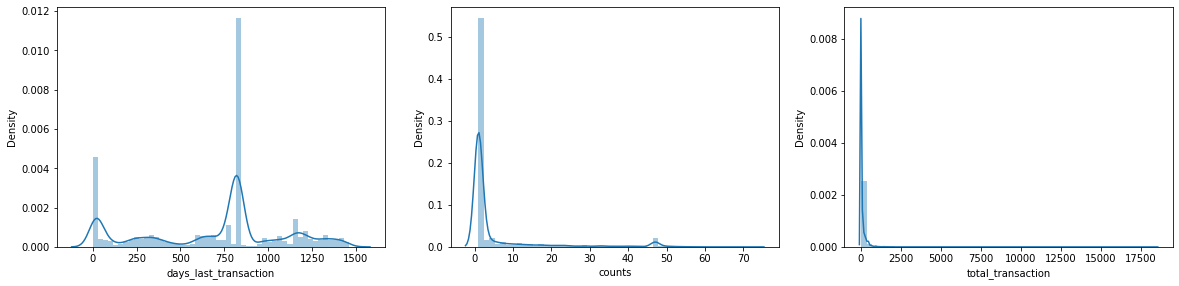

In [30]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.distplot(matrix['days_last_transaction'])
plt.subplot(3, 3, 2)
sns.distplot(matrix['counts'])
plt.subplot(3, 3, 3)
sns.distplot(matrix['total_transaction'])

as is possible to see, the distribution of the number of transaction per customer and the total donated amount are skewed, so we cannot use a quantile approach to find the cutoffs

In [31]:
def sorted_kmeans(df, metric_column, cluster_name, ascending=True, log=False):

    if log:
        df[metric_column] = np.log(df[metric_column]+1)

  
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df[[metric_column]])

    
    initial_cluster = 'unsorted_'+cluster_name
    df[initial_cluster] = kmeans.predict(df[[metric_column]])+1
    df[cluster_name] = df[initial_cluster]

    df_sorted = df.groupby(initial_cluster)[metric_column].mean().round(2).reset_index()
    df_sorted = df_sorted.sort_values(by=metric_column, ascending=ascending).reset_index(drop=True)
    df_sorted[cluster_name] = df_sorted[metric_column].rank(method='max', ascending=ascending).astype(int)

    df = df.merge(df_sorted[[cluster_name, initial_cluster]], on=[initial_cluster])
    df = df.drop(initial_cluster, axis=1)
    df = df.drop(cluster_name+'_x', axis=1)
    df = df.rename(columns={cluster_name+'_y':cluster_name})

    return df

after finding the optimal cutoff using kmeans we categorize our datas 

In [32]:
matrix = sorted_kmeans(matrix, 'days_last_transaction', 'score_days', ascending=True)
matrix = sorted_kmeans(matrix, 'counts', 'score_count', ascending=False)
matrix = sorted_kmeans(matrix, 'total_transaction', 'score_money', ascending=False)


here is our final result, less is the score, better it is 

In [33]:
matrix.head(10)

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money
0,2,7,90.0,14,1,3,4
1,76,9,210.0,63,1,3,4
2,1796,9,215.0,87,1,3,4
3,2188,10,206.0,173,1,3,4
4,2678,13,17.1,5,1,3,4
5,2869,9,225.0,178,1,3,4
6,4622,8,85.0,14,1,3,4
7,5848,9,150.0,160,1,3,4
8,5936,14,205.0,51,1,3,4
9,6382,9,170.0,4,1,3,4


as is possible to see from this plot the majority of customers are donating litte amounts (0-228 €)

In [34]:
matrix.groupby('score_money').agg(
    number_donors=('contact ID', 'count'),
    min_money=('total_transaction', min),
    max_money=('total_transaction', max),
    
)

,number_donors,min_money,max_money
score_money,,,
1,23,5890.0,18475.0
2,588,1120.0,5250.0
3,10839,228.6,1111.0
4,91009,0.0,228.0


the majority of customers donate only one time 

In [35]:
matrix.groupby('score_count').agg(
    number_donors=('contact ID', 'count'),
    min_count=('counts', min),
    max_count=('counts', max),
    
)

,number_donors,min_count,max_count
score_count,,,
1,5460,36,72
2,4331,19,35
3,7336,7,18
4,85332,1,6


In [36]:
matrix.groupby('score_days').agg(
    number_donors=('contact ID', 'count'),
    min_days=('days_last_transaction', min),
    max_days=('days_last_transaction', max),
    
)

,number_donors,min_days,max_days
score_days,,,
1,17711,0,185
2,12551,187,566
3,51236,567,1004
4,20961,1035,1460


In [37]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money
0,2,7,90.0,14,1,3,4
1,76,9,210.0,63,1,3,4
2,1796,9,215.0,87,1,3,4
3,2188,10,206.0,173,1,3,4
4,2678,13,17.1,5,1,3,4
...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1
102455,749756,47,6815.0,21,1,1,1
102456,766495,47,7050.0,21,1,1,1
102457,44891,29,6482.0,2,1,2,1


In [38]:
matrix['score_final'] = matrix.score_days.map(str)+matrix.score_count.map(str)+ matrix.score_money.map(str)


In [39]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
0,2,7,90.0,14,1,3,4,134
1,76,9,210.0,63,1,3,4,134
2,1796,9,215.0,87,1,3,4,134
3,2188,10,206.0,173,1,3,4,134
4,2678,13,17.1,5,1,3,4,134
...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102457,44891,29,6482.0,2,1,2,1,121


here are the top 5 customers

In [40]:
matrix[matrix['score_final']=='111'].sort_values('total_transaction', ascending=False).head(5)

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
102454,721508,47,14100.0,21,1,1,1,111
102452,30419,60,10200.0,21,1,1,1,111
102453,60445,52,7050.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111


In [41]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
0,2,7,90.0,14,1,3,4,134
1,76,9,210.0,63,1,3,4,134
2,1796,9,215.0,87,1,3,4,134
3,2188,10,206.0,173,1,3,4,134
4,2678,13,17.1,5,1,3,4,134
...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102457,44891,29,6482.0,2,1,2,1,121


lets illustrate our findings: 


*   best donors(111-222), those donors have donated the most often and spent the most.
*   big donators(XX1) those customers spend the most.

*   loyal donors(X1X) those donors  are the most loyal and donate more frequently
*   recent donors (1XX): customers that donated most recently 
*   almost lost(311-333): havent donated for some time, but when they did they donated frequently and a lot 
*   lost donors(411-443) havent donated for a lot of time, but donated a lot or  frequently 

*   cows(444): donated very little, not frequently, long time ago


In [42]:
matrix["segment"]=matrix["score_final"].apply(lambda x: "best_donors" if x=="111" else "almost lost" if x=="311" else "other_unassigned")

In [43]:
segment_grouped=matrix.groupby(["score_final"]).size().reset_index(name="number_of_occurrencies")

In [44]:
segment_grouped

,score_final,number_of_occurrencies
0,111,5
1,112,270
2,113,4787
3,114,55
4,121,2
5,122,58
6,123,1939
7,124,1205
8,131,2
9,132,54


In [45]:
matrix["segment"]="other_unassigned"

In [46]:
possibilities=list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,1,2,2,2], 3))])) #best donors list of clusters 
matrix.loc[matrix['score_final'].isin(possibilities), 'segment'] = 'best_donors'
possibilities_almost_lost=list(map(lambda x: "3"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3], 2))]))))
matrix.loc[matrix['score_final'].isin(possibilities_almost_lost), 'segment'] = 'almost lost'
possibilities_lost=list(map(lambda x: "4"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3,4], 2))]))))
matrix.loc[(matrix['score_final'].isin(possibilities_lost))&(matrix["segment"]=="other_unassigned"), 'segment'] = 'lost'
matrix.loc[(matrix['score_final']=="444"), 'segment'] = 'cow'
matrix.loc[(((matrix['score_money']==1)|(matrix['score_money']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'big donator'
matrix.loc[(((matrix['score_count']==1)|(matrix['score_count']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'loyal donor'
matrix.loc[(((matrix['score_days']==1)|(matrix['score_days']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'recent donor'


In [47]:
matrix[matrix["segment"]=="best_donors"]

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment
102094,1206,49,1285.0,21,1,1,2,112,best_donors
102095,1587,47,1175.0,21,1,1,2,112,best_donors
102096,1843,47,1410.0,21,1,1,2,112,best_donors
102097,2380,67,2495.0,21,1,1,2,112,best_donors
102098,4676,47,1410.0,21,1,1,2,112,best_donors
...,...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111,best_donors
102455,749756,47,6815.0,21,1,1,1,111,best_donors
102456,766495,47,7050.0,21,1,1,1,111,best_donors
102457,44891,29,6482.0,2,1,2,1,121,best_donors


In [48]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment
0,2,7,90.0,14,1,3,4,134,recent donor
1,76,9,210.0,63,1,3,4,134,recent donor
2,1796,9,215.0,87,1,3,4,134,recent donor
3,2188,10,206.0,173,1,3,4,134,recent donor
4,2678,13,17.1,5,1,3,4,134,recent donor
...,...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111,best_donors
102455,749756,47,6815.0,21,1,1,1,111,best_donors
102456,766495,47,7050.0,21,1,1,1,111,best_donors
102457,44891,29,6482.0,2,1,2,1,121,best_donors


In [49]:
list(map(lambda x: "3"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3], 2))]))))

['312', '332', '313', '333', '331', '321', '323', '322', '311']

In [50]:
list(map(lambda x: "4"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3,4], 2))]))))

['412',
 '432',
 '413',
 '441',
 '433',
 '431',
 '421',
 '414',
 '424',
 '423',
 '443',
 '422',
 '442',
 '434',
 '411']

In [51]:
matrix['score_final'].astype(str).str[2]=="1"

0         False
1         False
2         False
3         False
4         False
          ...  
102454     True
102455     True
102456     True
102457     True
102458     True
Name: score_final, Length: 102459, dtype: bool

In [52]:
merged_customers=contacts.merge(matrix[["contact ID","segment","counts","total_transaction","days_last_transaction"]], how="inner", left_on="ID_CTC", right_on="contact ID")

In [53]:
merged_customers=merged_customers.drop(columns=["contact ID","Unnamed: 0","EMAIL","DONATION_NUMBER","DONATION_AMOUNT","FIRST_DONATION_DATE","LAST_DONATION_DATE","YEAR_N_DONATION VOLUME","YEAR_N1_DONATION VOLUME","YEAR_N2_DONATION VOLUME","YEAR_N3_DONATION VOLUME","YEAR_N4_DONATION VOLUME","YEAR_N_DONATION_AMOUNT","YEAR_N1_DONATION_AMOUNT","YEAR_N2_DONATION_AMOUNT","YEAR_N3_DONATION_AMOUNT","YEAR_N4_DONATION_AMOUNT","STARTING_DATE_ACTIVE_PA",	"ENDING_DATE_ACTIVE_PA","ACTIVE_PA_CYCLE","DATE_LAST_ACTIVE_PA","ACTIVE_PA_ORIGIN","DEBIT_NUMBER","DEBIT_AMOUNT","FIRST_DEBIT_DATE","LAST_DEBIT_DATE","MIN_VALUE_OF_PURCHASE","FIRST_PURCHASE_DATE","LAST_PURCHASE_DATE","SUBSCRIPTION_NUMBER","SUBSCRIPTION_AMOUNT","FIRST_SUBSCRIPTION_DATE","LAST_SUBSCRIPTION_DATE","NOMBRE_PETITION","FIRST_PETITION_DATE","LAST_PETITION_DATE"])

In [54]:
merged_customers

,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,PA_ACTIVE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,segment,counts,total_transaction,days_last_transaction
0,2,PHYSICAL,NaN,19800101,NaN,no,NaN,no,/,NaN,NaN,yes,NaN,NaN,PA,PA,CIEL,4.00,10.0,0.0,14.0,235.00,recent donor,7,90.0,14
1,16,PHYSICAL,NaN,19931001,NaN,yes,FR,no,/,yes,NaN,NaN,NaN,NaN,VIAND,94EXCP2,FTEL1602DON48INA,41.22,40.0,0.0,2.0,4.58,other_unassigned,1,40.0,812
2,26,PHYSICAL,19661017.0,19910501,NaN,yes,FR,yes,no,yes,NaN,NaN,NaN,NaN,VARME,943AF4T,SITE,71.76,200.0,0.0,2.0,15.27,recent donor,6,730.0,54
3,55,PHYSICAL,19500702.0,19940609,NaN,yes,FR,yes,yes,yes,NaN,NaN,NaN,NaN,942AF6T,942AF6T,PA,15.27,6.0,1.0,9.0,10.00,loyal donor,50,422.0,0
4,76,PHYSICAL,19390101.0,19931220,NaN,yes,FR,yes,yes,yes,NaN,NaN,NaN,NaN,94EXCP2,94EXCP2,IA122,30.53,100.0,0.0,3.0,76.34,recent donor,9,210.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100669,1376608,PHYSICAL,NaN,20181004,NaN,yes,FR,no,/,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,30.00,30.0,0.0,0.0,NaN,recent donor,1,30.0,87
100670,1376610,PHYSICAL,NaN,20181004,NaN,yes,FR,yes,yes,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,60.00,60.0,0.0,0.0,NaN,recent donor,1,60.0,87
100671,1376616,PHYSICAL,NaN,20181005,NaN,yes,FR,no,/,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,100.00,100.0,0.0,0.0,NaN,recent donor,1,100.0,87
100672,1376618,PHYSICAL,NaN,20181005,NaN,yes,FR,yes,yes,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,50.00,50.0,0.0,0.0,NaN,recent donor,1,50.0,87


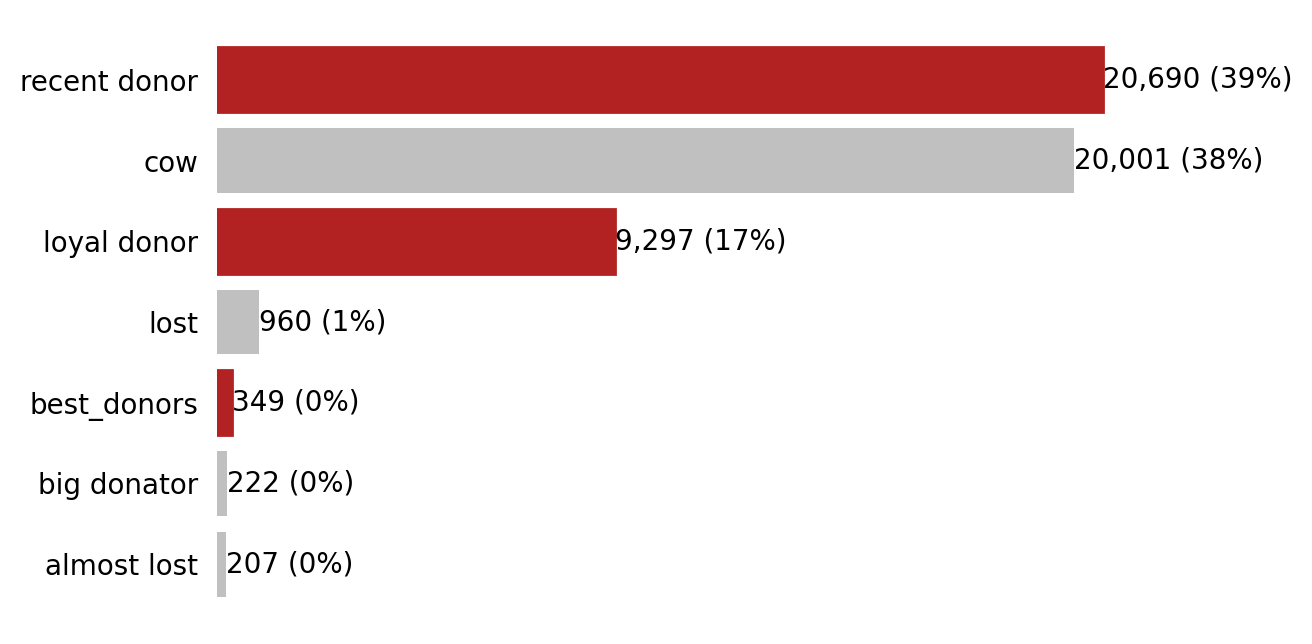

In [55]:

segments_counts = matrix[~matrix['segment'].str.contains('other_unassigned')]["segment"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()
fig.set_dpi(200)


bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['best_donors', 'loyal donor',"recent donor"]:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [56]:
segments_counts

almost lost       207
big donator       222
best_donors       349
lost              960
loyal donor      9297
cow             20001
recent donor    20690
Name: segment, dtype: int64

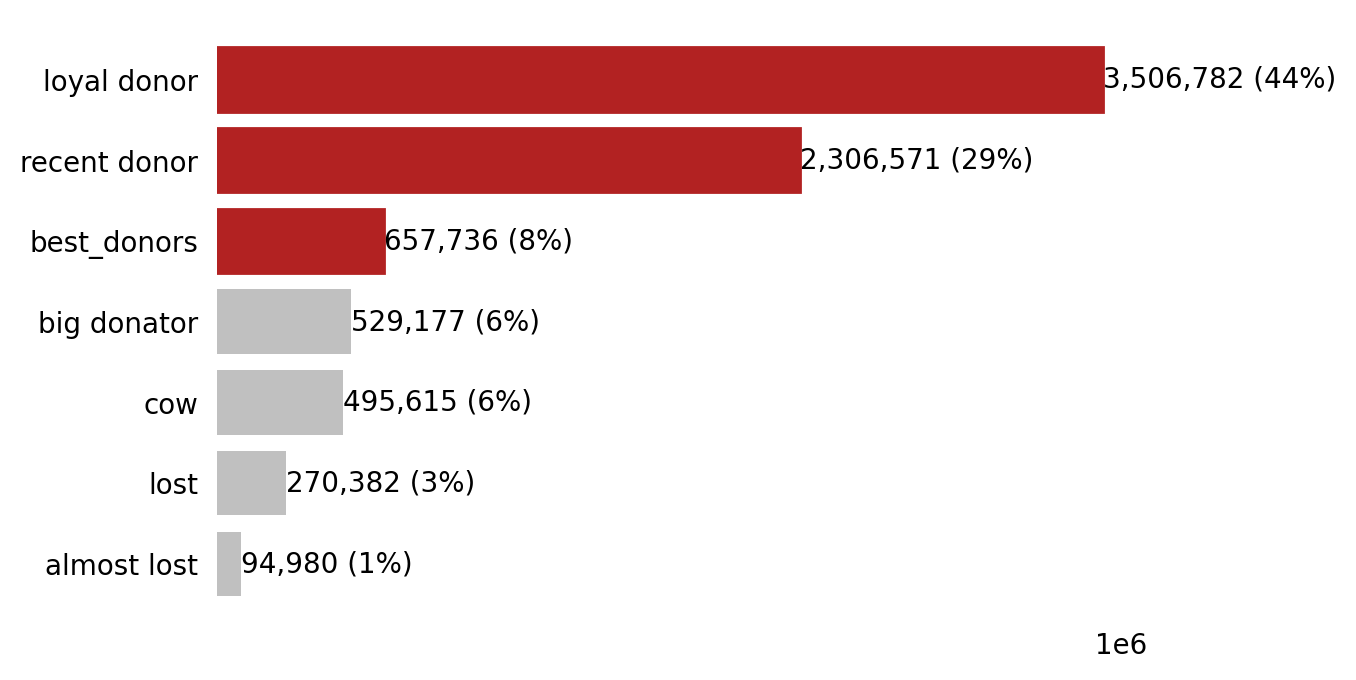

In [57]:
segments_sums = matrix[~matrix['segment'].str.contains('other_unassigned')].groupby(["segment"])["total_transaction"].agg('sum').sort_values(ascending=True)

fig, ax = plt.subplots()
fig.set_dpi(200)


bars = ax.barh(range(len(segments_sums)),
              segments_sums,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_sums)))
ax.set_yticklabels(segments_sums.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_sums.index[i] in ['best_donors', 'loyal donor',"recent donor"]:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_sums.sum())),
                va='center',
                ha='left'
               )

plt.show()


keep in mind that this analysis do not take in consideration the customers in the "other unassigned ", we focus only on the donors in the  specified segments to build an enforceble strategy 

In [58]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment
0,2,7,90.0,14,1,3,4,134,recent donor
1,76,9,210.0,63,1,3,4,134,recent donor
2,1796,9,215.0,87,1,3,4,134,recent donor
3,2188,10,206.0,173,1,3,4,134,recent donor
4,2678,13,17.1,5,1,3,4,134,recent donor
...,...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111,best_donors
102455,749756,47,6815.0,21,1,1,1,111,best_donors
102456,766495,47,7050.0,21,1,1,1,111,best_donors
102457,44891,29,6482.0,2,1,2,1,121,best_donors


In [59]:
segments_counts

almost lost       207
big donator       222
best_donors       349
lost              960
loyal donor      9297
cow             20001
recent donor    20690
Name: segment, dtype: int64

In [60]:

y = matrix["score_days"].to_numpy()
x = matrix["score_count"].to_numpy()
z = matrix["score_money"].to_numpy()
def pl(x,y,z,size=True): 

  fig = plt.figure(figsize = (16, 9))
  ax = plt.axes(projection ="3d")
   

  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.3,
         alpha = 0.2)
 
  combos = list(zip(x,y,z))
  weight_counter = Counter(combos)

  weights = [weight_counter[(x[i], y[i],z[i])] for i, _ in enumerate(x)]

  if size==True:
   sctt = ax.scatter3D(x, y, z,
                       alpha = 0.8,
                       c = (-x - y - z),
                       s=weights,
                       cmap=plt.get_cmap('hsv'),
                       marker ='o')
   cbar=plt.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
   cbar.set_label('final score')
   plt.title("totality of unaggregated segments, per final score",fontweight="bold")
  else:
     colors = {'best_donors':'red', 'almost lost':'green', 'lost':'blue', 'big donator':'yellow','loyal donor':'pink','recent donor':'violet','other_unassigned':'grey','cow':'black'}
     sctt = ax.scatter3D(x, y, z,
                       alpha = 0.8,
                       c=matrix['segment'].map(colors).to_numpy(),
                       
                       cmap=plt.get_cmap('hsv'),
                      
                       
                       marker ='o')
     markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
     plt.legend(markers, colors.keys(), numpoints=1)
     plt.title("segmented donors",fontweight="bold")
  
 
  
  ax.set_xlabel('number of donation', fontweight ='bold')
  ax.set_ylabel('last donation', fontweight ='bold')
  ax.set_zlabel('donated money', fontweight ='bold')


 

  plt.show()
  pass



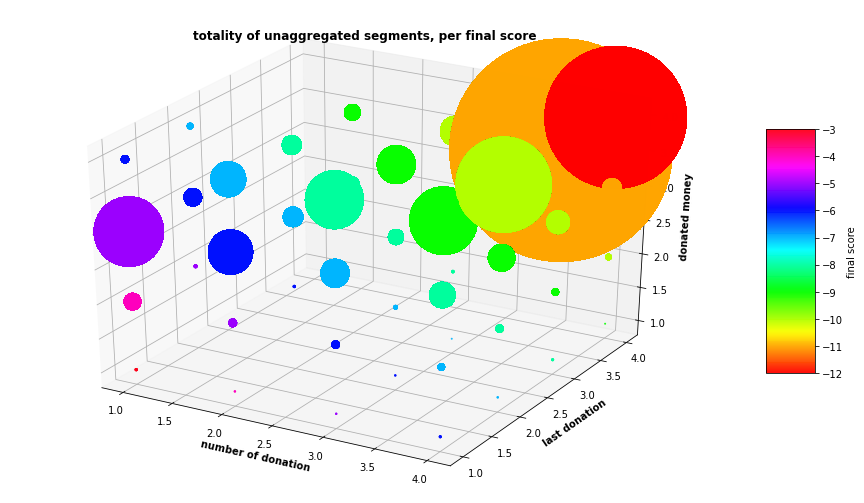

In [61]:
pl(x,y,z)

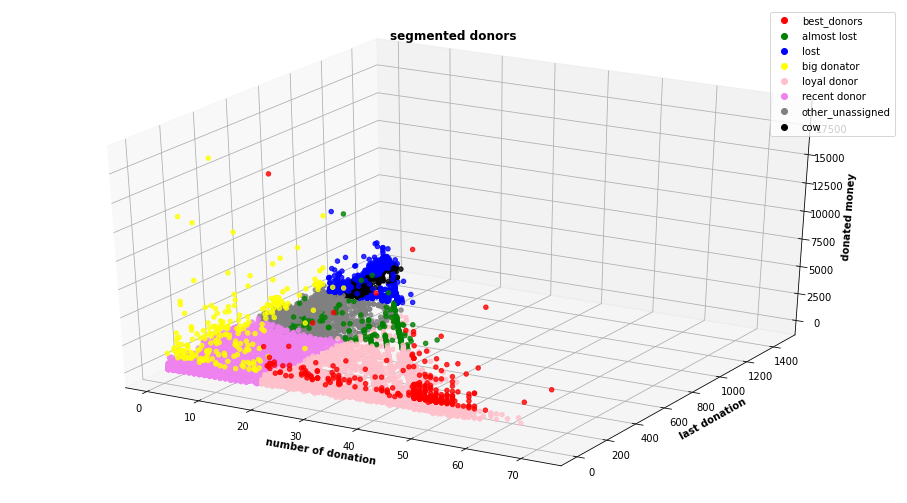

In [62]:
y = matrix["days_last_transaction"].to_numpy()
x = matrix["counts"].to_numpy()
z = matrix["total_transaction"].to_numpy()
pl(x,y,z,size=False)

In [63]:
segments_sums = matrix[~matrix['segment'].str.contains('other_unassigned')].groupby(["segment"])["total_transaction"].agg('sum').sort_values(ascending=True).reset_index(name="total_donated")

In [64]:
segments_sums

,segment,total_donated
0,almost lost,94980.71
1,lost,270382.72
2,cow,495615.49
3,big donator,529177.90
4,best_donors,657736.00
5,recent donor,2306571.27
6,loyal donor,3506782.39


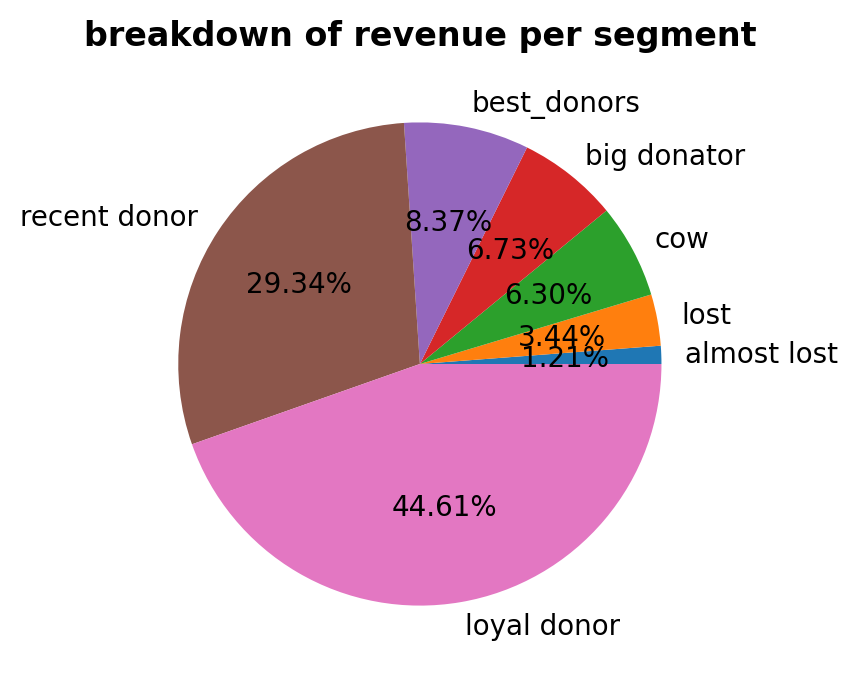

In [65]:
fig, ax = plt.subplots()
fig.set_dpi(200)


label=segments_sums["segment"].to_list()
counts=segments_sums["total_donated"].to_list()
ax.pie(counts, labels = label,autopct='%1.2f%%')
plt.title("breakdown of revenue per segment",fontweight="bold")
plt.show()

## <center>**analysis of customers** </center>

In [66]:
merged_customers

,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,PA_ACTIVE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,segment,counts,total_transaction,days_last_transaction
0,2,PHYSICAL,NaN,19800101,NaN,no,NaN,no,/,NaN,NaN,yes,NaN,NaN,PA,PA,CIEL,4.00,10.0,0.0,14.0,235.00,recent donor,7,90.0,14
1,16,PHYSICAL,NaN,19931001,NaN,yes,FR,no,/,yes,NaN,NaN,NaN,NaN,VIAND,94EXCP2,FTEL1602DON48INA,41.22,40.0,0.0,2.0,4.58,other_unassigned,1,40.0,812
2,26,PHYSICAL,19661017.0,19910501,NaN,yes,FR,yes,no,yes,NaN,NaN,NaN,NaN,VARME,943AF4T,SITE,71.76,200.0,0.0,2.0,15.27,recent donor,6,730.0,54
3,55,PHYSICAL,19500702.0,19940609,NaN,yes,FR,yes,yes,yes,NaN,NaN,NaN,NaN,942AF6T,942AF6T,PA,15.27,6.0,1.0,9.0,10.00,loyal donor,50,422.0,0
4,76,PHYSICAL,19390101.0,19931220,NaN,yes,FR,yes,yes,yes,NaN,NaN,NaN,NaN,94EXCP2,94EXCP2,IA122,30.53,100.0,0.0,3.0,76.34,recent donor,9,210.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100669,1376608,PHYSICAL,NaN,20181004,NaN,yes,FR,no,/,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,30.00,30.0,0.0,0.0,NaN,recent donor,1,30.0,87
100670,1376610,PHYSICAL,NaN,20181004,NaN,yes,FR,yes,yes,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,60.00,60.0,0.0,0.0,NaN,recent donor,1,60.0,87
100671,1376616,PHYSICAL,NaN,20181005,NaN,yes,FR,no,/,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,100.00,100.0,0.0,0.0,NaN,recent donor,1,100.0,87
100672,1376618,PHYSICAL,NaN,20181005,NaN,yes,FR,yes,yes,NaN,NaN,NaN,NaN,NaN,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,HUMACATFUND_INDONESIA,50.00,50.0,0.0,0.0,NaN,recent donor,1,50.0,87


In [67]:
merged_customers[merged_customers["COUNTRY"]=="ZA"]

,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,PA_ACTIVE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,segment,counts,total_transaction,days_last_transaction
15395,868131,PHYSICAL,NaN,20150302,NaN,yes,ZA,yes,no,NaN,NaN,NaN,NaN,NaN,WTR2015PFD,WTR2015PFD,WTR2015PFD,20.0,20.0,0.0,0.0,NaN,cow,1,20.0,1426
17293,879307,PHYSICAL,NaN,20150403,NaN,yes,ZA,yes,yes,NaN,NaN,NaN,NaN,NaN,TW2015PFD,TW2015PFD,TW2015PFD,150.0,150.0,0.0,0.0,NaN,cow,1,150.0,1387
30495,968270,PHYSICAL,NaN,20161206,NaN,yes,ZA,yes,no,NaN,NaN,NaN,NaN,NaN,TW2017PFD,TW2017PFD,TW2017PFD,30.0,30.0,0.0,0.0,NaN,other_unassigned,1,30.0,760
54779,1090331,PHYSICAL,NaN,20170706,NaN,no,ZA,yes,no,yes,NaN,NaN,NaN,NaN,O105FBVIDEOS,NaN,NaN,NaN,NaN,0.0,0.0,NaN,other_unassigned,1,0.0,822


In [68]:
count_country=merged_customers.groupby(["segment","COUNTRY"]).size().reset_index(name="number_of_occurrencies")

count_country[count_country["COUNTRY"]=="US"]

,segment,COUNTRY,number_of_occurrencies
21,big donator,US,2
99,cow,US,122
243,other_unassigned,US,172
303,recent donor,US,37


In [69]:
spent_country=merged_customers.groupby(["segment","COUNTRY"])['total_transaction'].agg('sum').reset_index(name="total_spent")
spent_country[spent_country["COUNTRY"]=="FR"]

,segment,COUNTRY,total_spent
2,almost lost,FR,87821.00
10,best_donors,FR,619787.00
18,big donator,FR,476204.73
53,cow,FR,430682.61
111,lost,FR,220777.32
124,loyal donor,FR,3476239.39
176,other_unassigned,FR,810557.26
270,recent donor,FR,2066444.80


In [70]:
spent_country[spent_country["segment"]=="best_donors"]

,segment,COUNTRY,total_spent
6,best_donors,BE,1645.0
7,best_donors,CH,19650.0
8,best_donors,DE,5250.0
9,best_donors,ET,1504.0
10,best_donors,FR,619787.0
11,best_donors,GF,4700.0
12,best_donors,IT,1410.0
13,best_donors,LU,1440.0
14,best_donors,TH,2350.0


In [71]:
countries=spent_country.COUNTRY.unique()
countries

array(['BE', 'ES', 'FR', 'GB', 'IE', 'IT', 'CH', 'DE', 'ET', 'GF', 'LU',
       'TH', 'HK', 'US', 'AE', 'AR', 'AT', 'AU', 'BA', 'BB', 'BD', 'BF',
       'BH', 'BJ', 'BR', 'BY', 'CA', 'CD', 'CG', 'CI', 'CL', 'CM', 'CN',
       'CO', 'CR', 'CY', 'DJ', 'DK', 'DO', 'DZ', 'FI', 'GN', 'GP', 'GR',
       'GW', 'HR', 'IN', 'JP', 'KE', 'KR', 'LT', 'MA', 'MC', 'MD', 'MG',
       'ML', 'MQ', 'MR', 'MU', 'MX', 'NC', 'NE', 'NL', 'NO', 'NT', 'PE',
       'PF', 'PH', 'PL', 'RE', 'RO', 'SA', 'SE', 'SG', 'SK', 'SN', 'TD',
       'TN', 'TR', 'UY', 'VA', 'VE', 'VN', 'ZA', 'GY', 'AL', 'AO', 'AZ',
       'BG', 'BO', 'BS', 'BZ', 'CU', 'CZ', 'EC', 'GT', 'HU', 'ID', 'IL',
       'IR', 'IS', 'JO', 'LB', 'LY', 'MM', 'MO', 'MT', 'MY', 'NR', 'NZ',
       'PA', 'PK', 'PM', 'PS', 'PT', 'QA', 'RU', 'RW', 'SB', 'SY', 'SZ',
       'TG', 'TW', 'UA', 'UG', 'UK', 'UZ', 'VU', 'YT', 'BM', 'NI'],
      dtype=object)

In [72]:
spent_country

,segment,COUNTRY,total_spent
0,almost lost,BE,3131.71
1,almost lost,ES,510.00
2,almost lost,FR,87821.00
3,almost lost,GB,2548.00
4,almost lost,IE,250.00
...,...,...,...
300,recent donor,TH,150.00
301,recent donor,TR,50.00
302,recent donor,UK,2465.00
303,recent donor,US,4383.00


In [73]:
import pycountry
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country_flag(df):
    if (df['COUNTRY'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['COUNTRY']).name
    
    else:
        
        return 'Invalid Code'

In [74]:
pycountry.countries.search_fuzzy('GB')[0].name

'United Kingdom'

In [75]:
spent_country1=spent_country.copy()

In [76]:
spent_country1['COUNTRY']=spent_country.apply(country_flag, axis = 1)

In [86]:
spent_country=spent_country1[spent_country1['COUNTRY']!="Invalid Code"]

In [87]:
spent_country

,segment,COUNTRY,total_spent
0,almost lost,Belgium,3131.71
1,almost lost,Spain,510.00
2,almost lost,France,87821.00
3,almost lost,United Kingdom,2548.00
4,almost lost,Ireland,250.00
...,...,...,...
299,recent donor,Slovakia,20.00
300,recent donor,Thailand,150.00
301,recent donor,Turkey,50.00
303,recent donor,United States,4383.00


In [88]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
def geolocate_lat(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.latitude
    except:
        # Return missing value
        return np.nan

In [89]:
def geolocate_lon(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.longitude
    except:
        # Return missing value
        return np.nan

In [90]:
spent_country["latitude"]=spent_country["COUNTRY"].apply(geolocate_lat)
spent_country["longitude"]=spent_country["COUNTRY"].apply(geolocate_lon)

In [96]:
spent_country=spent_country.dropna()

In [97]:
spent_country

,segment,COUNTRY,total_spent,latitude,longitude
0,almost lost,Belgium,3131.71,50.640281,4.666715
1,almost lost,Spain,510.00,39.326068,-4.837979
2,almost lost,France,87821.00,46.603354,1.888334
3,almost lost,United Kingdom,2548.00,54.702354,-3.276575
4,almost lost,Ireland,250.00,52.865196,-7.979460
...,...,...,...,...,...
299,recent donor,Slovakia,20.00,48.741152,19.452865
300,recent donor,Thailand,150.00,14.897192,100.832730
301,recent donor,Turkey,50.00,38.959759,34.924965
303,recent donor,United States,4383.00,39.783730,-100.445882


In [157]:

from sklearn.preprocessing import minmax_scale

spent_country["radius"]=spent_country.groupby(["COUNTRY"])["total_spent"].transform(lambda x: minmax_scale(x.astype(float),(2,30)))


In [158]:
spent_country[spent_country['COUNTRY']=="Switzerland"]


,segment,COUNTRY,total_spent,latitude,longitude,radius
7,best_donors,Switzerland,19650.0,46.813331,8.444947,30.000000
16,big donator,Switzerland,16788.0,46.813331,8.444947,25.302146
38,cow,Switzerland,6005.0,46.813331,8.444947,7.602298
106,lost,Switzerland,5167.7,46.813331,8.444947,6.227905
120,loyal donor,Switzerland,4203.0,46.813331,8.444947,4.644390
161,other_unassigned,Switzerland,10197.0,46.813331,8.444947,14.483292
258,recent donor,Switzerland,2592.0,46.813331,8.444947,2.000000


In [176]:
spent_country[(spent_country["COUNTRY"]!="France")&(spent_country["segment"]=="best_donors")]["total_spent"].sum()

37949.0

In [166]:
france_rev=spent_country[spent_country["COUNTRY"]=="France"]

In [181]:
france_rev=france_rev.rename(columns={"total_spent":"France revenue"})

In [168]:
no_france_rev=spent_country[spent_country["COUNTRY"]!="France"]

In [172]:
no_france_rev=no_france_rev.groupby("segment")["total_spent"].apply(sum).reset_index()

In [178]:
no_france_rev=no_france_rev.rename(columns={"total_spent": "rest of the world"})

In [179]:
no_france_rev

,segment,rest of the world
0,almost lost,6844.71
1,best_donors,37949.00
2,big donator,44175.50
3,cow,62627.88
4,lost,48437.00
5,loyal donor,26896.00
6,other_unassigned,120962.41
7,recent donor,139160.74


In [183]:
rev_merged=france_rev.merge(no_france_rev,how="inner",left_on="segment",right_on="segment")

In [185]:
rev_merged=rev_merged.drop(columns=["COUNTRY","latitude","longitude","radius"])

In [186]:
rev_merged

,segment,France revenue,rest of the world
0,almost lost,87821.00,6844.71
1,best_donors,619787.00,37949.00
2,big donator,476204.73,44175.50
3,cow,430682.61,62627.88
4,lost,220777.32,48437.00
5,loyal donor,3476239.39,26896.00
6,other_unassigned,810557.26,120962.41
7,recent donor,2066444.80,139160.74


In [190]:
rev_merged.set_index('segment')

,France revenue,rest of the world
segment,,
almost lost,87821.00,6844.71
best_donors,619787.00,37949.00
big donator,476204.73,44175.50
cow,430682.61,62627.88
lost,220777.32,48437.00
loyal donor,3476239.39,26896.00
other_unassigned,810557.26,120962.41
recent donor,2066444.80,139160.74


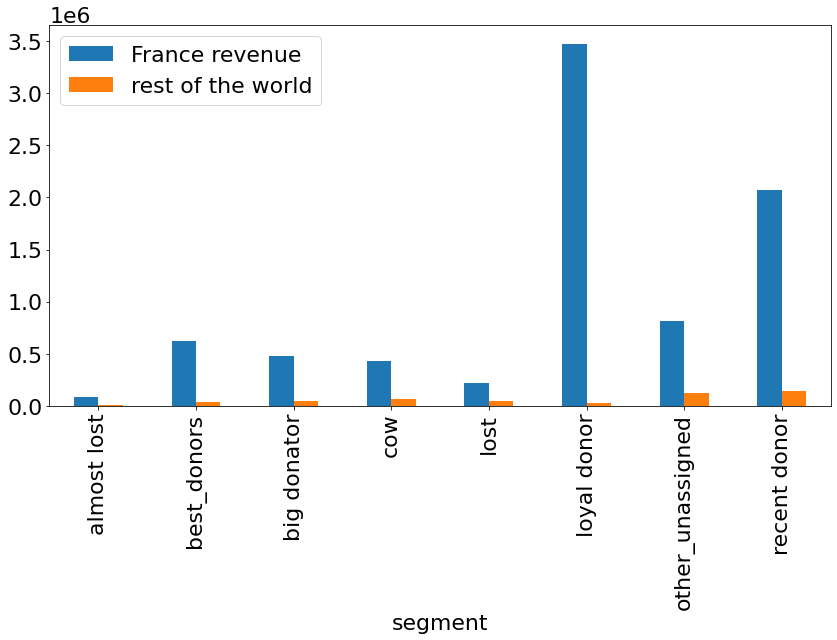

In [209]:
plt.rcParams.update({'font.size': 22})
rev_merged.set_index("segment").plot.bar(figsize=(14,7))

In [244]:
def color_list():
    rand=[random.randint(0,16777215) for i in range(len(rev_merged))]
    hexrand=list(map(str,list(map(hex,rand))))
    hexrand=list(map(lambda x: '#'+ x[2:],hexrand))
    return hexrand






colors=["#FF69B4","#FF0000","#00FF00","#0000FF","#CD5C5C","Tomato","Orange","DodgerBlue"]


In [245]:
colors

['#FF69B4',
 '#FF0000',
 '#00FF00',
 '#0000FF',
 '#CD5C5C',
 'Tomato',
 'Orange',
 'DodgerBlue']

In [246]:
spent_country

,segment,COUNTRY,total_spent,latitude,longitude,radius
0,almost lost,Belgium,3131.71,50.640281,4.666715,2.815554
1,almost lost,Spain,510.00,39.326068,-4.837979,2.000000
2,almost lost,France,87821.00,46.603354,1.888334,2.000000
3,almost lost,United Kingdom,2548.00,54.702354,-3.276575,6.266978
4,almost lost,Ireland,250.00,52.865196,-7.979460,2.000000
...,...,...,...,...,...,...
299,recent donor,Slovakia,20.00,48.741152,19.452865,30.000000
300,recent donor,Thailand,150.00,14.897192,100.832730,3.787234
301,recent donor,Turkey,50.00,38.959759,34.924965,30.000000
303,recent donor,United States,4383.00,39.783730,-100.445882,4.300852


In [247]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [266]:

import folium
from folium.plugins import MarkerCluster

world_map= folium.Map(tiles="cartodbpositron",location=[44.262997, 11.068795], zoom_start=3, width='100%', height='60%')
marker_cluster = MarkerCluster().add_to(world_map)
res = {rev_merged["segment"].iloc[i]: colors[i] for i in range(len(rev_merged))}
for i in range(len(spent_country)):
        lat = spent_country.iloc[i]['latitude']
        long = spent_country.iloc[i]['longitude']
        radius1=spent_country.iloc[i]['radius']
       
        
        folium.CircleMarker(
        location=[lat, long],
        radius=radius1,
    
       color=res[spent_country["segment"].iloc[i]],
       
       
      ).add_to(world_map)
world_map=add_categorical_legend(world_map, 'My title',
                             colors = res.values(),
                           labels = res.keys())
world_map

Text(0.5, 1.0, 'percentage of donors types by country')

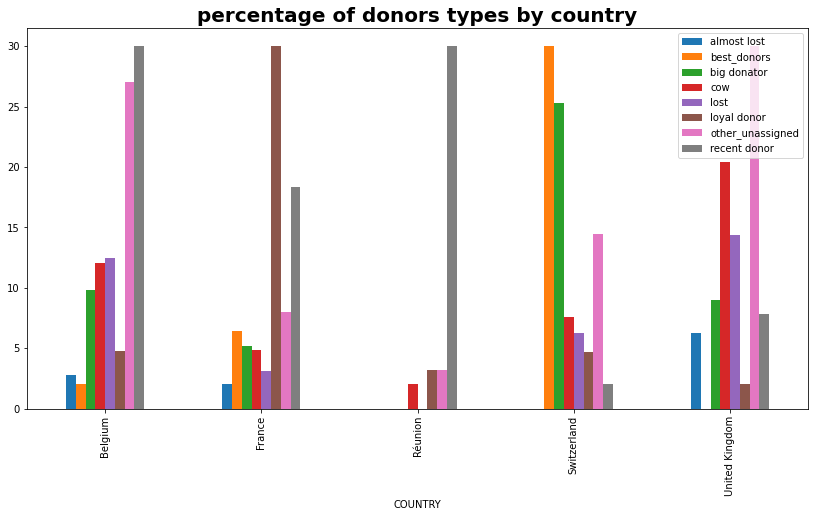

In [302]:
top5country=spent_country.groupby("COUNTRY")["total_spent"].apply(sum).reset_index(name="total_donated").sort_values(by='total_donated', ascending=False).head(5)
top5country
top5country=spent_country[spent_country["COUNTRY"].isin(top5country["COUNTRY"])]
plt.rcParams.update({'font.size': 10})
top5country.pivot(index="COUNTRY", columns='segment', values='radius').plot(kind='bar',figsize=(14,7))
plt.legend(loc="topright")
plt.title("percentage of donors types by country",fontweight="bold",size=20)